In [2]:
from birdcall.data import *

import pandas as pd
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
from torch.utils.data import Dataset

In [3]:
recs = pd.read_pickle('data/recs.pkl')

In [176]:
#export data

import scipy

def audio_to_spec(audio):
    f, t, spec = scipy.signal.spectrogram(audio, fs=SAMPLE_RATE)#, nperseg=360)
    spec = np.log10(spec.clip(1e-10))
    return spec[10:100]
    spec = librosa.power_to_db(
#         librosa.feature.melspectrogram(audio, sr=SAMPLE_RATE, fmin=20, fmax=16000, n_mels=224, hop_length=360)
        librosa.feature.melspectrogram(audio, sr=SAMPLE_RATE, fmin=20, fmax=16000, n_mels=128)
#         librosa.feature.melspectrogram(audio, sr=SAMPLE_RATE, hop_length=1255, fmin=20, fmax=16000)
    )
    return spec

In [198]:
#export data

import matplotlib.pyplot as plt

class SpectrogramDataset(Dataset):
    def __init__(self, recs, classes, len_mult=20, spec_min=None, spec_max=None):
        self.recs = recs
        self.vocab = classes
        self.do_norm = (spec_min and spec_max)
        self.spec_min = spec_min
        self.spec_max = spec_max
        self.len_mult = len_mult
    def __getitem__(self, idx):
        cls_idx = idx % len(self.vocab)
        recs = self.recs[classes[cls_idx]]
        path, duration = recs[np.random.randint(0, len(recs))]
        if duration > 5:
            x, _ = sf.read(path, start=int(np.random.rand() * (duration-5) * SAMPLE_RATE), frames=5*SAMPLE_RATE)
        else:
            x, _ = sf.read(path)
            x =  np.tile(x, 15) # the shortest rec in the train set is 0.39 sec
            start_frame = int(np.random.rand() * (x.shape[0] - 5 * SAMPLE_RATE))
            x = x[start_frame:start_frame+5*SAMPLE_RATE]
        if x.shape[0] != 5 * SAMPLE_RATE: raise Exception(f'Incorrect length: {x.shape[0]}, {path}, {duration}')
        x = audio_to_spec(x)
        if self.do_norm: x = self.normalize(x)
        img = np.repeat(x[None, :, :], 3, 0)
            
        return img.astype(np.float32), self.one_hot_encode(cls_idx)
    def normalize(self, x):
        return ((x - x.min()) / (x.max() - x.min() + 1e-8) - 0.11754986) / 0.16654329
        x = (x - self.spec_min) / (self.spec_max - self.spec_min)
        return (x - 0.36829123) / 0.08813263
    
    def show(self, idx):
        x = self[idx][0]
        x = (x * 0.36829123) + 0.08813263
        return plt.imshow(x.transpose(1,2,0)[:, :, 0])
        
    def one_hot_encode(self, y):
        one_hot = np.zeros((len(self.vocab)))
        one_hot[y] = 1
        return one_hot
    def __len__(self):
        return self.len_mult * len(self.vocab)

In [199]:
import numpy as np

In [200]:
classes = pd.read_pickle('data/classes.pkl')
train_ds = SpectrogramDataset(pd.read_pickle('data/train_set.pkl'), classes, spec_max=80, spec_min=-100)
valid_ds = SpectrogramDataset(pd.read_pickle('data/val_set.pkl'), classes, len_mult=10)

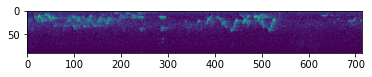

In [201]:
train_ds.show(0)

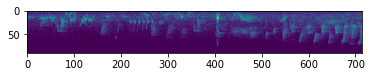

In [202]:
valid_ds.show(0)

In [203]:
%%time
x = []
for i in range(264*5):
    x.append(train_ds[i][0])

CPU times: user 9.44 s, sys: 168 ms, total: 9.61 s
Wall time: 11.1 s


In [204]:
np.stack(x).max(), np.stack(x).min(), np.stack(x).mean(), np.stack(x).std()

(5.298623, -0.70582163, -0.019333018, 0.9874333)